In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt

In [2]:
adj_matrix = pd.read_csv("data/science.add9330_data_s1/Supplementary-Data-S1/all-all_connectivity_matrix.csv", index_col=0)

nodes = pd.read_csv("node_properties_clean.csv")

In [38]:
# Convert the adjacency matrix to an edge list
edge_list = adj_matrix.stack().reset_index().rename(columns={"level_0": "source", "level_1": "target", 0: "weight"})
# Filter out values where column "0" has value 0
edge_list = edge_list.loc[edge_list.weight != 0]
# Convert all to integer
edge_list = edge_list.astype(int)

In [39]:
filtered_nodes = pd.DataFrame({ "node": edge_list.source.unique()})
filtered_nodes = pd.merge(filtered_nodes, nodes, left_on='node', right_on='skid', how='inner')
filtered_nodes.celltype = filtered_nodes.celltype.fillna("Unknown")

In [40]:
# Create a dictionary mapping node names to indices
node_to_index = {node: int(index) for index, node in enumerate(filtered_nodes['skid'])}
# Apply it to the edge list
edge_list['source'] = edge_list['source'].map(node_to_index)
edge_list['target'] = edge_list['target'].map(node_to_index)
# Apply it to the node list
filtered_nodes['skid'] = filtered_nodes['skid'].map(node_to_index)

In [41]:
# Remove rows with NaN values
edge_list = edge_list.dropna().astype(int)
edge_list

,source,target,weight
1,0,1,9
2,0,2,1
26,0,25,2
27,0,26,6
162,0,155,5
...,...,...,...
8704414,2561,1688,4
8704943,2561,2160,1
8705086,2561,2270,2
8705204,2561,2366,1


In [42]:
# Create a graph-tool graph from the edge list
g = gt.Graph(directed=True)
g.add_edge_list(edge_list.values, hashed=True)

# Add a vertex property map for cell types
celltypes = g.new_vertex_property("string")
for node in filtered_nodes.itertuples():
    celltypes[g.vertex(node.skid)] = node.celltype

In [43]:
# Create a mapping from cell types to hexadecimal colors
def create_color():
    return '#%02x%02x%02x' % (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

In [44]:
unique_annotations = filtered_nodes['celltype'].unique()
celltype_to_color = {annotation: create_color() for annotation in unique_annotations}

# Create a vertex property for colour
colors = g.new_vertex_property("string")
for node in filtered_nodes.itertuples():
    colors[g.vertex(node.skid)] = celltype_to_color[node.celltype]

In [53]:
# Draw the graph with a sfdp layout
pos = gt.sfdp_layout(g)

p = gt.graph_draw(g, pos=pos, vertex_fill_color=colors, output_size=(1000, 1000), vertex_size=10, output="temp_graph.png")

In [54]:
# Create a legend from the cell types to the colors
legend = {celltype: plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=15) for celltype, color in celltype_to_color.items()}


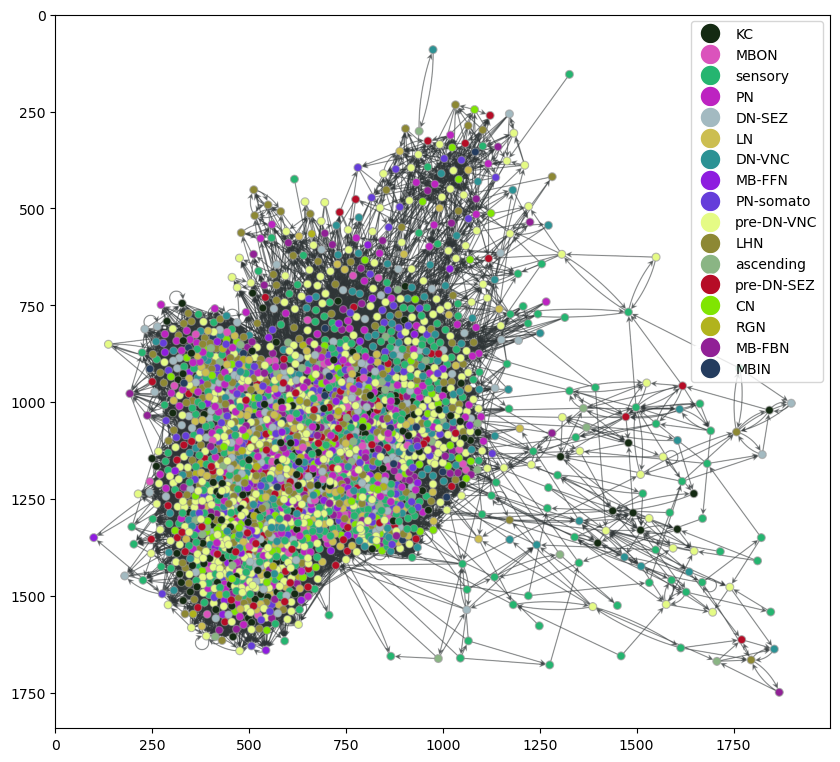

In [56]:
# Now using matplotlib, load the graph image and add the legend
fig, ax = plt.subplots(figsize=(10, 10))
# Load the graph image
img = plt.imread('temp_graph.png')
ax.imshow(img)

plt.legend(handles=legend.values(), loc='upper right')
plt.show()